Load data from yahoo finance

In [1]:
!pip install yfinance

     |████████████████████████████████| 6.3MB 10.6MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=c232a4644b18c148019c99912b57f0ee4e458918fd0f9d966030fecc51a0de9a
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from datetime import datetime
import yfinance as yf

In [2]:
#paicc
# ticker '2318.HK'
PAICC=yf.download('2318.HK','2010-01-05',end='2021-01-05')
PAICC=PAICC.reset_index()
PAICC.shape


[*********************100%***********************]  1 of 1 completed


(2664, 7)

In [3]:
PAICC.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-05,33.799999,35.099998,33.750000,35.000000,29.252539,27460382
1,2010-01-06,35.299999,35.650002,34.974998,35.375000,29.565956,26959426
2,2010-01-07,35.674999,35.674999,34.799999,35.049999,29.294325,24715978
3,2010-01-08,35.125000,35.375000,34.625000,34.950001,29.210751,13257738
4,2010-01-11,35.750000,36.000000,35.325001,35.575001,29.733120,20433656


In [4]:
PAICC['Close'].rolling( window=10,min_periods=1).mean().fillna(PAICC['Close'][0])

0       35.000000
1       35.187500
2       35.141666
3       35.093750
4       35.190000
          ...    
2659    92.960001
2660    92.945001
2661    93.060001
2662    93.200002
2663    93.125002
Name: Close, Length: 2664, dtype: float64

In [5]:
PAICC['Close'].rolling( window=10,min_periods=1).std()
#.fillna(SP500['Close'][0])

0            NaN
1       0.265165
2       0.203613
3       0.191893
4       0.271915
          ...   
2659    1.102472
2660    1.094544
2661    1.148381
2662    1.309156
2663    1.209051
Name: Close, Length: 2664, dtype: float64

In [6]:
#(SSE['Close'].shift(1)/5+SSE['Close'].shift(2)/5+SSE['Close'].shift(3)/5+SSE['Close'].shift(4)/5+SSE['Close']/5)
PAICC['MA5_close']=PAICC['Close'].rolling( window=5,min_periods=1).mean()
PAICC['STD5_close']=PAICC['Close'].rolling( window=5,min_periods=1).std()
PAICC['STD5_close']=PAICC['STD5_close'].fillna(PAICC['Close'][70])
# SP500['MA5_close']=SP500['Close'].shift(1).rolling( window=,min_periods=1).mean().fillna(SP500['Close'][0])
# SP500['STD5_close']=SP500['Close'].shift(1).rolling( window=5,min_periods=1).std()
# SP500['STD5_close']=SP500['STD5_close'].fillna(SP500['Close'][9])


In [7]:
#fill nan
#SP500['STD5_close'][0]=SP500['STD5_close'].mean()
PAICC.head()

,Date,Open,High,Low,Close,Adj Close,Volume,MA5_close,STD5_close
0,2010-01-05,33.799999,35.099998,33.750000,35.000000,29.252539,27460382,35.000000,34.525002
1,2010-01-06,35.299999,35.650002,34.974998,35.375000,29.565956,26959426,35.187500,0.265165
2,2010-01-07,35.674999,35.674999,34.799999,35.049999,29.294325,24715978,35.141666,0.203613
3,2010-01-08,35.125000,35.375000,34.625000,34.950001,29.210751,13257738,35.093750,0.191893
4,2010-01-11,35.750000,36.000000,35.325001,35.575001,29.733120,20433656,35.190000,0.271915


In [8]:
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader

class StockDataset(Dataset):

    def __init__(self, data, seq_len=5):

        super(StockDataset, self).__init__()

        self.names = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume','MA5_close','STD5_close']
        #self.dfs = [pd.read_csv(file, sep='\t', names=self.names) for file in files]
        self.data=data
        self.length = len(data) - seq_len
        self.seq_len = seq_len

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        
       

        new_idx = idx if idx < self.length else self.length-1
        
        data, target = self.generate_batch(self.data, self.seq_len, start_from=new_idx, batch_size=1)

        data = torch.from_numpy(data).type(torch.FloatTensor).squeeze()
        target = torch.from_numpy(target).type(torch.FloatTensor).squeeze()

        return data, target
    
    def count_number_of_samples(self, filepath, n_features):
        df = pd.read_csv(filepath)
        return len(df) - n_features - 1

    def generate_batch(self, dataframe, seq_len, start_from, batch_size):

        data = []
        target = []

        bs = min(batch_size, len(dataframe) - start_from)

        dataframe['Date'] = pd.to_datetime(dataframe['Date'])
        df = dataframe.sort_values('Date').drop('Date', axis=1)
        # next create ma5 and normaliosation !!!
        for column in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume','MA5_close','STD5_close']:
          #shifted MA5
          std_fill=df[column].rolling(window=5,min_periods=1).std()[5]
          factor=1/df[column].rolling(window=5,min_periods=1).std().fillna(std_fill)
          factor[factor>500000]=df[column].max()
          factor[factor.isna()]=1
          #df[column]=(df[column]-df[column].shift(1).rolling(window=5,min_periods=1).mean().fillna(df[column][0]))/df[column].shift(1).rolling(window=5,min_periods=1).std().fillna(std_fill)
          #df[column][df[column].]=500000

          df[column]=(df[column]-df[column].rolling(window=5,min_periods=1).mean().fillna(df[column][0]))*factor
        for i in range(bs):
            tar = df['Close'][start_from + seq_len + i]
           
            data_row = df[start_from + i:start_from + seq_len + i].values
            
            target.append(tar)
            data.append(data_row)

        target = np.array(target).ravel()
        data = np.vstack([elem[None, ...] for elem in data])
        
       
        assert data.shape == (bs, seq_len, df.values.shape[1])
        

        assert target.shape == (bs,)

        return data, target

In [9]:
# PAICC (2664, 7)
bs=100 # batch size
horizon=5
#Divide into train and validation dataset
train_dataset=StockDataset(PAICC[:2000],seq_len=horizon)
val_dataset=StockDataset(PAICC[2000:],seq_len=horizon)

#creating dataloader 
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

In [10]:
PAICC.shape

(2664, 9)

In [16]:
for data, target in train_loader:
    print(data.shape)
    print(data.isinf().any())
    print(data.isnan().any())
    print(target.isnan().any())
    print(target.shape)
    

torch.Size([100, 5, 8])
tensor(False)
tensor(False)
tensor(False)
torch.Size([100])
torch.Size([100, 5, 8])
tensor(False)
tensor(False)
tensor(False)
torch.Size([100])
torch.Size([100, 5, 8])
tensor(False)
tensor(False)
tensor(False)
torch.Size([100])
torch.Size([100, 5, 8])
tensor(False)
tensor(False)
tensor(False)
torch.Size([100])
torch.Size([100, 5, 8])
tensor(False)
tensor(False)
tensor(False)
torch.Size([100])
torch.Size([100, 5, 8])
tensor(False)
tensor(False)
tensor(False)
torch.Size([100])
torch.Size([100, 5, 8])
tensor(False)
tensor(False)
tensor(False)
torch.Size([100])
torch.Size([100, 5, 8])
tensor(False)
tensor(False)
tensor(False)
torch.Size([100])
torch.Size([100, 5, 8])
tensor(False)
tensor(False)
tensor(False)
torch.Size([100])
torch.Size([100, 5, 8])
tensor(False)
tensor(False)
tensor(False)
torch.Size([100])
torch.Size([100, 5, 8])
tensor(False)
tensor(False)
tensor(False)
torch.Size([100])
torch.Size([100, 5, 8])
tensor(False)
tensor(False)
tensor(False)
torch.Size

Models Generator and Discriminator

In [11]:
class Generator(nn.Module):
    def __init__(self,input_size=7, hidden_size=horizon):
        super().__init__()
        # input size: (seq_len, batch, input_size)
        #output of shape (seq_len, batch, num_directions * hidden_size):
        self.lstm=nn.LSTM(input_size=input_size,hidden_size=1,num_layers=1)
        #[bs,horizon,7]
        self.fulcon=nn.Sequential(nn.Linear(hidden_size,1,bias=True), nn.LeakyReLU(),nn.Dropout())
    def forward(self, input_seq):
        bs, seq_len=input_seq.shape[0], input_seq.shape[1]
        input_seq=input_seq.permute(1,0,2)
        out,_=self.lstm(input_seq)
        out=out.permute(1,0,2)
       
        out=out.reshape(bs,seq_len)
        y=self.fulcon(out)
        #[bs,1]
        return y

In [12]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
#DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")    
horizon=5 #predict for 5 days
generator=Generator(input_size=8, hidden_size=horizon)
bs=100
N_epochs=30
criteria=nn.BCEWithLogitsLoss()
Discriminator=nn.Sequential(
    nn.Linear(horizon+1,72,bias=True),
    nn.LeakyReLU(),
    nn.Linear(72,100,bias=True),
    nn.LeakyReLU(),
    nn.Linear(100,10,bias=True),
    nn.LeakyReLU(),
    nn.Linear(10,1,bias=True),
    #nn.Sigmoid()
    
)
Discriminator=Discriminator.to(device)
generator=generator.to(device)
D_opt = torch.optim.Adam(Discriminator.parameters(), lr=0.001, betas=(0.0, 0.999))
G_opt = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.0, 0.999))

#Validation
val_dataset=StockDataset(PAICC[2000:],seq_len=horizon)
val_dataset.data=val_dataset.data.reset_index().drop('index',axis=1)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

Training loop

In [13]:
lambda1=0.5
lambda2=0.5

train_loss_disc=[]
train_loss_gen=[]
rmse_plot=[]
mae_plot=[]
for epoch in range(N_epochs):
    Discriminator.train()
    generator.train()
    for itera, batch in enumerate(train_loader):
        #now target is just close price

        X_data, target = batch 
        
        X_data=X_data.to(device)
        target=target.to(device)
        #data is normalised
        bs=target.shape[0]
        #zeroes??
        fake_labels=torch.zeros([bs, 1]).to(device)
        true_labels=torch.ones([bs, 1]).to(device)
        
        gen_output=generator(X_data).detach()
        #vector of close prices 
        sequnce_6days=torch.cat([X_data[:,:,3], gen_output], dim=1)
        
        D_gen_loss=criteria(Discriminator(sequnce_6days), fake_labels)
        # index of close price is 3 
        
        true_seqeunce=torch.cat([X_data[:,:,3], target[:, None]],axis=1)
        # true_seqeunce Size is [bs, seq_len+1]
  
        D_true_loss=criteria(Discriminator(true_seqeunce), true_labels)
        
        D_loss = D_true_loss+D_gen_loss
        
        D_opt.zero_grad()
        D_loss.backward()
        D_opt.step()
        
        if itera%5:
            #let us train generator:
            gen_output=generator(X_data)
            #target is close price 
            
            # gen_output [bs,1] target [bs,] is meaned over batche items
            G_mse=torch.mean((gen_output-target[:,None])**2)
            
            sequnce_6days=torch.cat([X_data[:,:,3], gen_output], dim=1)
            
            G_logloss=-criteria(Discriminator(sequnce_6days), fake_labels)
          
            G_loss= lambda1*G_logloss + lambda2*G_mse
          
            G_opt.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        # model.eval()
        
        if itera%100:

            if itera%1000:
                print('Epoch:',epoch)
                print('train loss Discriminator',D_loss.item())
                print('train loss Generator',G_loss.item())
                
            train_loss_disc.append(D_loss.item())
            train_loss_gen.append(G_loss.item())
      
    generator.eval()
    Discriminator.eval()


    generated_seqeunce_val=[]
    target_seqeunce_val=[]
    with torch.no_grad():

      mae_test=0
      rmse_test=0
      mape_test=0
      ar_test=0
      for iter, batch in enumerate(val_loader):
          data, target=batch
          data = data.to(device)
          target = target.to(device)
          generator_output=generator(data).detach()         
          generator_output= generator_output.squeeze(0)
        
          generated_seqeunce_val.append(generator_output.item())  
          target_seqeunce_val.append(target.item()) 
          mae_test+=torch.mean(torch.abs(generator_output-target)).item()
          rmse_test += torch.sqrt(torch.mean((generator_output-target)**2)).item()
          mape_test+=torch.mean(torch.abs(generator_output-target)/(target+0.0000001)).item()
          if iter>0:
              if generated_seqeunce_val[iter]>generated_seqeunce_val[iter-1]:
                  ar_test+=target_seqeunce_val[iter]-target_seqeunce_val[iter-1]
          
      mae_test=mae_test/len(val_loader)
      rmse_test=rmse_test/len(val_loader)
      mape_test=mape_test/len(val_loader)
      ar_test=ar_test/(len(val_loader)-1)

      rmse_plot.append(rmse_plot)
      mae_plot.append(mae_test)
      print('Epoch :',epoch,', MAE val: ',mae_test)
      print('Epoch :',epoch,', RMSE val: ',rmse_test)
      print('Epoch :',epoch,', MAPE val: ',mape_test)
      print('Epoch :',epoch,', AR val: ',ar_test)

            

Epoch: 0
train loss Discriminator 1.3893275260925293
train loss Generator 0.10740622878074646
Epoch: 0
train loss Discriminator 1.384958028793335
train loss Generator 0.20916470885276794
Epoch: 0
train loss Discriminator 1.3813942670822144
train loss Generator 0.16652241349220276
Epoch: 0
train loss Discriminator 1.3758231401443481
train loss Generator 0.22994938492774963
Epoch: 0
train loss Discriminator 1.3722789287567139
train loss Generator 0.22994938492774963
Epoch: 0
train loss Discriminator 1.3638986349105835
train loss Generator 0.2355591058731079
Epoch: 0
train loss Discriminator 1.3550652265548706
train loss Generator 0.26971209049224854
Epoch: 0
train loss Discriminator 1.3549710512161255
train loss Generator 0.13837739825248718
Epoch: 0
train loss Discriminator 1.3493525981903076
train loss Generator 0.18880659341812134
Epoch: 0
train loss Discriminator 1.347219705581665
train loss Generator 0.18880659341812134
Epoch: 0
train loss Discriminator 1.3347729444503784
train loss

Validation of the model for SSE close price

In [15]:
print('Epoch :',epoch,', MAE val: ',mae_test)
print('Epoch :',epoch,', RMSE val: ',rmse_test)
print('Epoch :',epoch,', MAPE val: ',mape_test)
print('Epoch :',epoch,', AR val: ',ar_test)

Epoch : 29 , MAE val:  0.8660157794734867
Epoch : 29 , RMSE val:  0.8660157794734867
Epoch : 29 , MAPE val:  -33.107421046504484
Epoch : 29 , AR val:  -0.036298768445657596


In [14]:
val_dataset=StockDataset(PAICC[2000:],seq_len=horizon)
val_dataset.data=val_dataset.data.reset_index().drop('index',axis=1)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

generator.eval()

generated_seqeunce_val=[]
target_seqeunce_val=[]
with torch.no_grad():

  mae_test=0
  rmse_test=0
  mape_test=0
  ar_test=0
  for iter, batch in enumerate(val_loader):
      data, target=batch
      data = data.to(device)
      target = target.to(device)
      generator_output=generator(data).detach()         
      generator_output= generator_output.squeeze(0)
     
      generated_seqeunce_val.append(generator_output.item())  
      target_seqeunce_val.append(target.item()) 
      
      mae_test+=torch.mean(torch.abs(generator_output-target)).item()
      rmse_test += torch.sqrt(torch.mean((generator_output-target)**2)).item()
      mape_test+=torch.mean(torch.abs(generator_output-target)/(target+0.0000001)).item()
      if iter>0:
          if generated_seqeunce_val[iter]>generated_seqeunce_val[iter-1]:
              ar_test+=target_seqeunce_val[iter]-target_seqeunce_val[iter-1]
      
  mae_test=mae_test/len(val_loader)
  rmse_test=rmse_test/len(val_loader)
  mape_test=mape_test/len(val_loader)
  ar_test=ar_test/(len(val_loader)-1)
  print('MAE val: ',mae_test)
  print('RMSE val: ',rmse_test)
  print('MAPE val: ',mape_test)
  print('AR val: ',ar_test)



  #print(f'Epoch {epoch} \t Train loss {train_loss} \t Test loss {test_loss}')

MAE val:  0.8660157794734867
RMSE val:  0.8660157794734867
MAPE val:  -33.107421046504484
AR val:  -0.036298768445657596


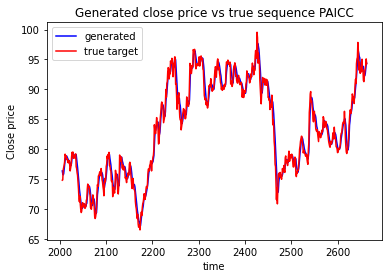

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.xlabel('time')
plt.ylabel('Close price')

plt.title('Generated close price vs true sequence PAICC')
horizon=5
#plt.plot(SP500.loc[2000+horizon:,'MA5_close'],label='mov averge 10 days',c='green')

plt.plot(generated_seqeunce_val*PAICC.loc[2000+horizon:, 'STD5_close']+PAICC.loc[2000+horizon:,'MA5_close'],label='generated',c='blue')
plt.plot(PAICC.loc[2000+horizon:,'Close'], label='true target',c='red')
#plt.plot(SP500.loc[2000+horizon:,'MA5_close'], label='moving average',c='green')
plt.legend()


In [ ]:
plt.plot(rmse_plot)

Text(0, 0.5, 'Train Loss')

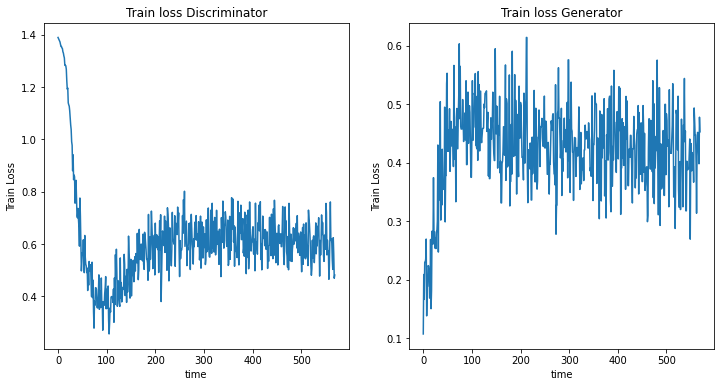

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axs=plt.subplots(nrows=1,ncols=2,figsize=[12,6])

axs[0].set_title('Train loss Discriminator')
axs[0].plot(train_loss_disc)
axs[1].set_title('Train loss Generator')
axs[1].plot(train_loss_gen)

#
axs[1].set_xlabel('time')
axs[0].set_xlabel('time')
axs[0].set_ylabel('Train Loss')
axs[1].set_ylabel('Train Loss')

In [21]:
train_all = DataLoader(train_dataset, batch_size=2000, shuffle=True)


for X_all, target in train_all:
  X_all,target=X_all.to(device),target.to(device)
  gen_output=generator(X_all)
 
 

In [22]:
gen_output=gen_output.detach().cpu().numpy()

In [ ]:
list(gen_output.squeeze(1))*PAICC.loc[horizon+1:2000, 'STD5_close']+PAICC.loc[horizon+1:2000,'MA5_close']

Text(0, 0.5, 'closing price')

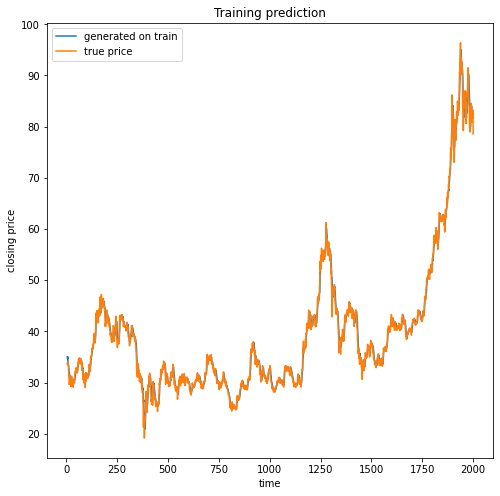

In [24]:
plt.figure(figsize=[8,8])
horizon=5
plt.title('Training prediction')
plt.plot(list(gen_output.squeeze(1))*PAICC.loc[horizon+1:2000, 'STD5_close']+PAICC.loc[horizon+1:2000,'MA5_close'] ,label='generated on train')
plt.plot(PAICC.loc[6:2000,'Close'],label='true price')
plt.legend()
plt.xlabel('time')
plt.ylabel('closing price')

Text(0, 0.5, 'closing price')

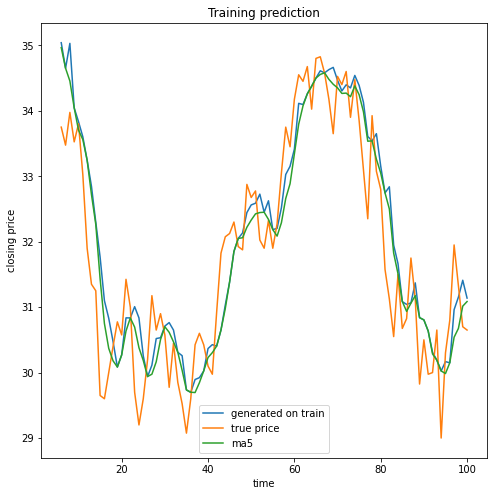

In [28]:
plt.figure(figsize=[8,8])
horizon=5
plt.title('Training prediction')
plt.plot(list(gen_output.squeeze(1))[:95]*PAICC.loc[horizon+1:100, 'STD5_close']+PAICC.loc[horizon+1:100,'MA5_close'] ,label='generated on train')
plt.plot(PAICC.loc[horizon+1:100,'Close'],label='true price')
plt.plot(PAICC.loc[horizon+1:100,'MA5_close'],label='ma5')

plt.legend()
plt.xlabel('time')
plt.ylabel('closing price')
